In [1]:
from PIL import Image
import numpy as np
import inspect
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import torch
from torchvision.transforms import (
    RandomHorizontalFlip, RandomVerticalFlip, RandomAffine, RandomResizedCrop, ToTensor, Grayscale, Compose, RandomInvert
)
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
def normalize(x, invert=True):
    x = (x - x.min()) / (x.max() - x.min())
    if invert:
        x = 1 - x
    return x

def to_img(x, invert=True):
    if invert:
        x = 1 - x
    return ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8)

def to_array(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
def scale(x, clip_to=0.6):
    x = np.maximum(x, 0)
    return np.minimum((x / clip_to) ** 2, 1.0)

def overlay(img, overlay_arr=None, figsize=(14, 18), ax=None, color=None, overlay_color=(255, 0, 0), dilate=True): # red
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if color:
        img_ = []
        for i in color:
            img_ += [img]
        img = np.stack(img_, axis=2)
    else:
        img = np.stack([img, img, img], axis=2)
    if overlay_arr is not None:
        if dilate:
            overlay_arr = cv2.dilate(overlay_arr, kernel=np.ones((3, 3), np.uint8))
        overlay_img = np.zeros_like(img, np.uint8)
        overlay_img[:,:] = np.array(overlay_color)
        img = (img * (1 - overlay_arr)[:,:,None] + overlay_img * overlay_arr[:,:,None]).astype(np.uint8)
    ax.imshow(img)
    
def overlay_img(img, overlay_arr=None, figsize=(14, 18), ax=None, color=None, overlay_color=(0, 0, 0)): # red
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if color:
        img_ = []
        for i in color:
            img_ += [img]
        img = np.stack(img_, axis=2)
    else:
        img = np.stack([img, img, img], axis=2)
    if overlay_arr is not None:
        overlay_arr = np.stack([overlay_arr, overlay_arr, overlay_arr], axis=2)
        img = np.minimum(img, overlay_arr)
    ax.imshow(img)
    
def imshow(img, ax=None, figsize=(14, 18)):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img)

In [3]:
img2 = Image.open('roughness-study/loose_2.jpg')
img2_clean = Image.open('roughness-study/rough_2.jpg')

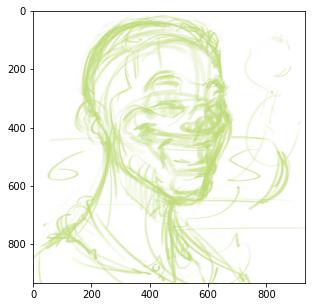

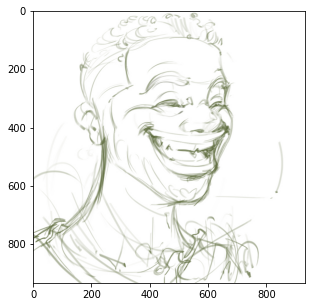

In [313]:
imshow(img2, figsize=(5, 5))
imshow(img2_clean, figsize=(5, 5))

In [4]:
img = Image.open('roughness-study/rough_1.jpg')
img_clean = Image.open('roughness-study/clean_1.jpg')
w, h = img.size
img = img.resize((w//4, h//4))
img_clean = img_clean.resize((w//4, h//4))
gray = to_array(img)
gray_clean = to_array(img_clean)
# normalize rough sketch so that the maximum line intensity is same as clean sketch
gray = to_img(gray, invert=False)

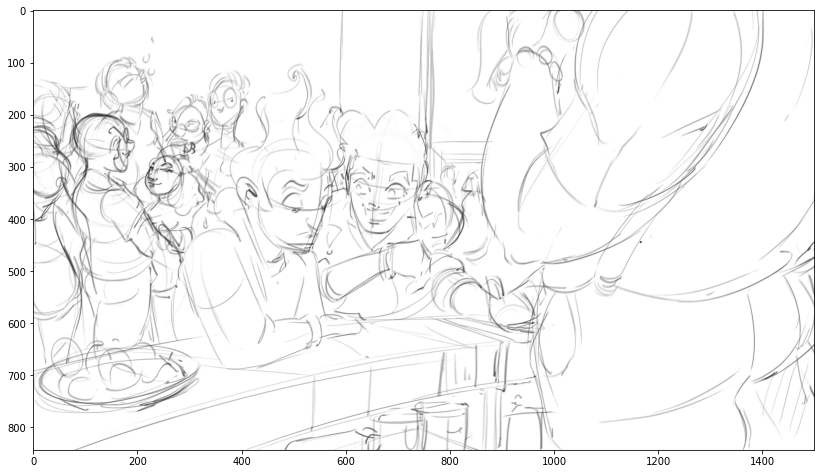

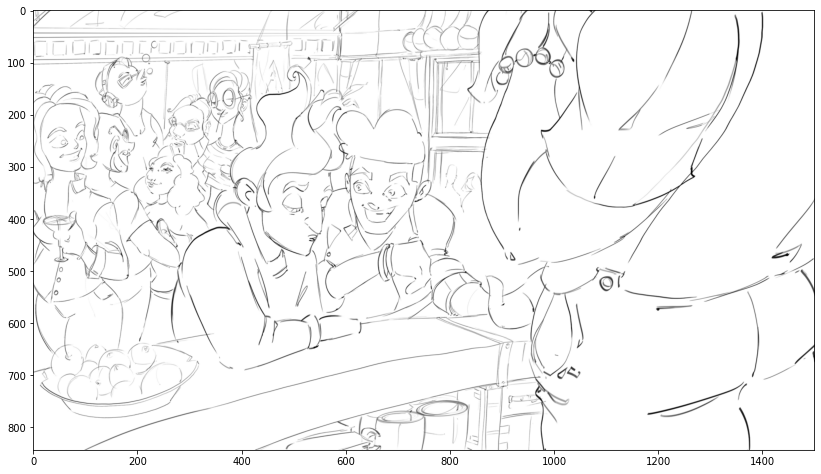

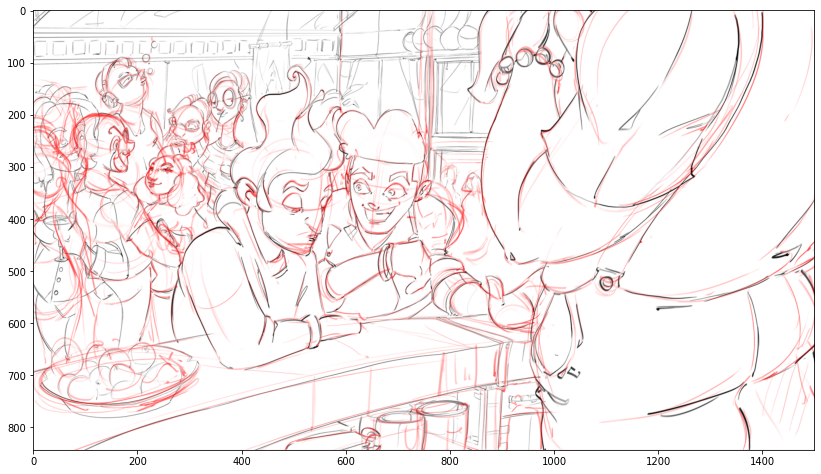

In [12]:
overlay(gray)
overlay(gray_clean)
overlay(gray_clean, normalize(gray), dilate=False)

### 1. Learn to output clean sketch patches directly
Data:
 - Aligned clean/rough sketch data
 - Augment aligned data:
     - Use high-intensity pixels as clean lines in rough sketches
     - Overlay randomly transformed versions of the original image to create rough sketch from clean

#### a. Try overlaying clean sketch patches to create rough sketch data

In [24]:
x, y = gray.shape

In [26]:
resize = RandomResizedCrop((100, 100), (0.05, 0.06))

In [51]:
x_off = 20
y_off = 1
gray_offset = np.zeros_like(gray_clean)
gray_offset[x_off:,y_off:] = gray_clean[:-x_off,:-y_off]

In [66]:
gray_offset

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 251, 255, ..., 255, 255, 255],
       [  0, 251, 255, ..., 255, 255, 255],
       [  0, 251, 255, ..., 255, 255, 255]], dtype=uint8)

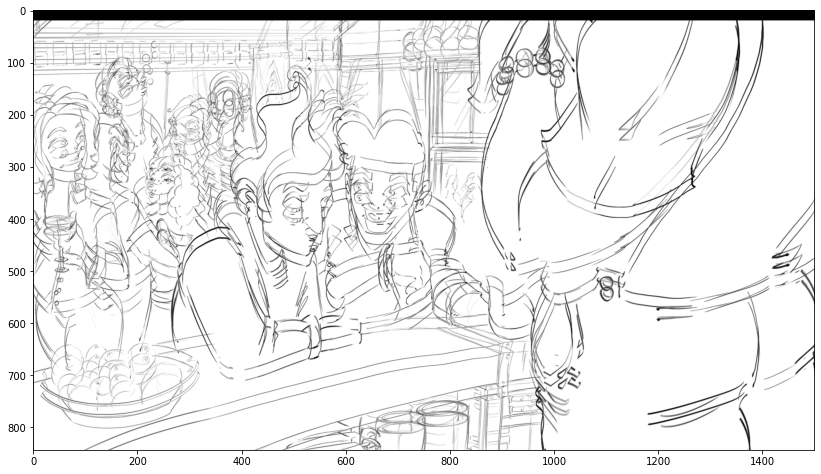

In [68]:
overlay_img(gray_clean, gray_offset)

In [33]:
resize(ToTensor()(gray)).numpy()[0].shape

(100, 100)

### Create Custom Augmentation for Sketch roughening

In [12]:
Image.Image

PIL.Image.Image

In [151]:
class RandomRoughening(torch.nn.Module):
    def __init__(
        self,
        overlays=(1, 4),
        degrees=(-10, 10),
        translate=(0, 0.1),
        scale=(0.8, 1.2),
        shear=(0, 0),
    ):
        super().__init__()
        self.grayscale = Grayscale()
        self.affine = RandomAffine(degrees=degrees, translate=translate, scale=scale, shear=shear, fill=255)
        self.min_overlays, self.max_overlays = overlays
        
    def forward(self, x, **kwargs):
        g = self.grayscale(x)
        arr = np.array(g)
        for _ in range(torch.randint(self.min_overlays, self.max_overlays, (1,)).item()):
            # try different things
            arr = np.minimum(arr, np.array(self.affine(g)))
        return Image.fromarray(arr.astype(np.uint8))

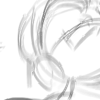

In [185]:
RandomRoughening(overlays=(1, 4))(Image.fromarray(np.array(img)[100:200, 100:200]))

In [55]:
transform = Compose([
    RandomResizedCrop((16, 16), scale=(0.02, 0.1), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.5),
    RandomRoughening(degrees=10),
])

### Create Custom Dataloader For Applying Same Transform to Aligned Images

In [36]:
FILL_BACKGROUND = 0

class ImagePairTransform:
    def __init__(
        self,
        size=(224, 224),
        scale=(0.1, 1.),
        ratio=(0.75, 1.3),
        hflip_ratio=0.5,
        vflip_ratio=0.5,
        degrees=(0, 0),
        translate=(0, 0),
        scale_range=(1, 1),
        shear=(0, 0),
        same_transform=False,
        normalize=None,
    ):
        # Whether to apply same transform to both images (initial crop is always same)
        self.same_transform = same_transform
        # RandomResizedCrop params
        self.size = size
        self.scale = scale
        self.ratio = ratio
        # RandomAffine params
        self.degrees = degrees
        self.translate = translate
        self.scale_range = scale_range
        self.shear = shear
        # Other Transformations
        self._GrayScale = Grayscale()
        self._Invert = RandomInvert(1.0)
        self._random_crop = RandomResizedCrop(size=size, scale=scale, ratio=ratio)
        self._random_hflip = RandomHorizontalFlip(hflip_ratio)
        self._random_vflip = RandomVerticalFlip(vflip_ratio)
        self._random_affine = RandomAffine(
            degrees=self.degrees, translate=self.translate, scale=self.scale_range, shear=self.shear, fill=FILL_BACKGROUND
        )
        self._hflip_ratio = hflip_ratio
        self._vflip_ratio = vflip_ratio
        
        self._normalize = normalize
        
    def _RandomResizedCrop(self, image1, image2, same=True):
        if same:
            params = RandomResizedCrop.get_params(image1, self.scale, self.ratio)
            return TF.resized_crop(image1, *params, size=self.size), TF.resized_crop(image2, *params, size=self.size)
        return self._random_crop(image1), self._random_crop(image2)
    
    def _RandomHorizontalFlip(self, image1, image2, same=True):
        if same:
            if np.random.rand() < self._hflip_ratio:
                return TF.hflip(image1), TF.hflip(image2)
            return image1, image2
        return self._random_hflip(image1), self._random_hflip(image2)
    
    def _RandomVerticalFlip(self, image1, image2, same=True):
        if same:
            if np.random.rand() < self._vflip_ratio:
                return TF.vflip(image1), TF.vflip(image2)
            return image1, image2
        return self._random_vflip(image1), self._random_vflip(image2)
    
    def _RandomAffine(self, image1, image2, same=True):
        if same:
            params = RandomAffine.get_params(self.degrees, self.translate, self.scale_range, self.shear, image1.size)
            return TF.affine(image1, *params, fill=FILL_BACKGROUND), TF.affine(image2, *params, fill=FILL_BACKGROUND)
        return self._random_affine(image1), self._random_affine(image2)
        
    def __call__(self, image1, image2, normalize=True, same_transform=None):
        if same_transform is None:
            same_transform = self.same_transform
        image1, image2 = self._GrayScale(image1), self._GrayScale(image2)
        out = self._Invert(image1), self._Invert(image2)
        out = self._RandomResizedCrop(*out, same=True)
        out = self._RandomHorizontalFlip(*out, same=same_transform)
        out = self._RandomVerticalFlip(*out, same=same_transform)
        image1, image2 = self._RandomAffine(*out, same=same_transform)
        image1, image2 = TF.to_tensor(image1), TF.to_tensor(image2)
        if normalize and self._normalize:
            image1, image2 = self._normalize(image1), self._normalize(image2)
        return image1, image2

class SketchPairLoader:
    def __init__(self, clean, rough, transform):
        self.clean = clean
        self.rough = rough
        self.transform = transform
    def sample(self, normalize=True, same_transform=None):
        return self.transform(self.clean, self.rough, normalize=normalize, same_transform=same_transform)
    def batch(self, size=512, normalize=True, same_transform=None):
        return torch.stack(
            [
                torch.stack(
                    self.sample(normalize=normalize, same_transform=same_transform), dim=0
                ) for _ in range(size)
            ], dim=0
        )

In [37]:
def normalize_patch(patch, eps=1e-10):
    sum_ = patch.sum()
    return patch / (sum_ + eps), sum_

transform = ImagePairTransform(degrees=(-15, 15), scale=(0.05, 0.2), normalize=lambda x: normalize_patch(x)[0])
train_loader = SketchPairLoader(img_clean, img, transform)
val_loader = SketchPairLoader(img2_clean, img2, transform)

In [123]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce
def pairwise_predict(paired_logits):
    batch_size = paired_logits.shape[0] // 2
    logits = paired_logits.reshape(batch_size, 2)
    logits = logits[:,0] - logits[:,1]
    return logits  # log-likelihood that 1st in pair is the cleanest

def prepare_batch(batch, image_size=224):
    batch = batch.reshape(batch.shape[0] * 2, 1, image_size, image_size)
    return batch.repeat(1, 3, 1, 1)  # expand to 3-channel image

def prepare_single(img):
    return img.repeat(3, 1, 1)[None]

In [22]:
from torchvision.models import resnet18
model = resnet18(num_classes=1)

In [23]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
lr = 1e-1
lrd = 0.995
optim = SGD(params=model.parameters(), momentum=0.9, lr=lr)
scheduler = ExponentialLR(optimizer=optim, gamma=lrd)

In [ ]:
train_iters = 1000
train_batch_size = 10
val_batch_size = 50
eval_every = 10

train_set = prepare_batch(train_loader.batch(size=val_batch_size)).cuda()
val_set = prepare_batch(val_loader.batch(size=val_batch_size)).cuda()
labels = torch.ones(train_batch_size).cuda()  # 1st in pair always comes from the clean sketch
labels_val = torch.ones(val_batch_size).cuda()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

model.cuda()
for i in range(train_iters):
    train_batch = prepare_batch(train_loader.batch(size=train_batch_size)).cuda()
    
    paired_logits = model(train_batch)
    
    loss = bce(pairwise_predict(paired_logits), labels)
    loss.backward()

    optim.step()
    optim.zero_grad()
    scheduler.step()
    
    if i % eval_every == 0:
        with torch.no_grad():
            # compute train loss / accuracy
            pred = pairwise_predict(model(train_set))
            train_loss = bce(pred, labels_val).item()
            train_acc = (pred > 0).sum() / val_batch_size

            pred = pairwise_predict(model(val_set))
            val_loss = bce(pred, labels_val).item()
            val_acc = (pred > 0).sum() / val_batch_size

            print(f"Iteration {i}: train_loss={train_loss}, train_acc={train_acc}, val_loss={val_loss}, val_acc={val_acc}")
            train_losses += [train_loss]
            val_losses += [val_loss]
            train_accs += [train_accs]
            val_accs += [val_accs]

### Visualize what model has learned by optimizing inputs

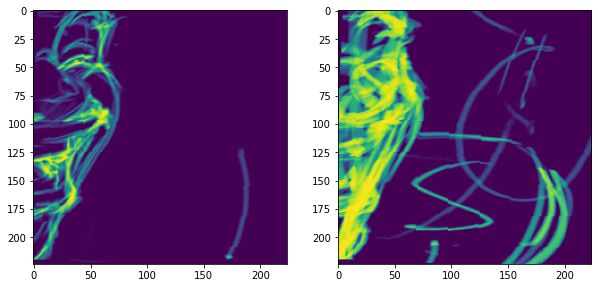

In [160]:
test_clean, test_rough = val_loader.sample(normalize=False, same_transform=True)
_, ax = plt.subplots(1, 2, figsize=(10, 5))
imshow(TF.to_pil_image(test_clean), ax=ax[0])
imshow(TF.to_pil_image(test_rough), ax=ax[1])

In [ ]:
model.eval()

In [243]:
def clean_image(img, model, num_steps=1, step_size=0.2):
    norm, img_sum = normalize_patch(img)
    for _ in tqdm(range(num_steps)):
        norm.requires_grad = True
        inp = prepare_single(norm)
        out = model(inp.cuda())
        out.backward()
        model.zero_grad()
        norm = update_patch(norm, patch_sum=img_sum, step=step_size)
    return norm[0]
        
def update_patch(patch_tensor, patch_sum=None, step=0.2):
    with torch.no_grad():
        grad = patch_tensor.grad.clone().cpu()
        return np.maximum(patch_tensor.clone().cpu() * (patch_sum if patch_sum else 1) + grad * step, 0)
    
def visualize_patch(patch_tensor, ax=None, figsize=(5, 5)):
    img = TF.to_pil_image(patch_tensor)
    imshow(img, ax=ax, figsize=figsize)

def update_patch_and_visualize(patch_tensor, step=0.2, patch_sum=None, ax=None, figsize=(5, 5)):
    patch = update_patch(patch_tensor, step=step, patch_sum=patch_sum)
    visualize_patch(patch, ax=ax, figsize=figsize)
    

In [193]:
test_rough.sum()

tensor(2232.2708)

In [260]:
cleaned_inp = clean_image(test_rough, model, step_size=5e-3, num_steps=1)

  0%|          | 0/1 [00:00<?, ?it/s]

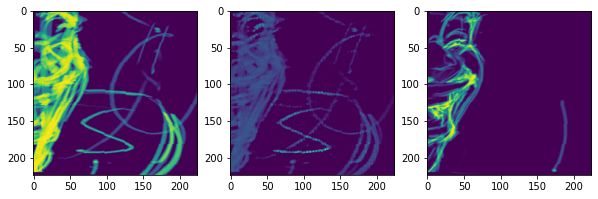

In [261]:
_, ax = plt.subplots(1, 3, figsize=(10, 5))
imshow(TF.to_pil_image(test_rough), ax=ax[0])
visualize_patch(cleaned_inp, ax=ax[1])
imshow(TF.to_pil_image(test_clean), ax=ax[2])

In [161]:
clean_input, clean_sum = normalize_patch(test_clean)
rough_input, rough_sum = normalize_patch(test_rough)
rough_input.requires_grad = True

In [66]:
out_clean, out_rough = model(
    prepare_batch(torch.stack([clean_input, rough_input])[None]).cuda()
)

In [67]:
print(out_rough.item())
out_rough.backward()

-19.9768009185791


In [68]:
rough_input.grad

tensor([[[-0.7326, -3.4842, -4.2653,  ...,  0.5724,  0.0000,  0.0000],
         [-1.1043, -3.8589, -5.5496,  ...,  0.3220,  0.0000,  0.0000],
         [-1.3223, -5.1724, -6.0423,  ...,  0.0952,  0.0000,  0.0000],
         ...,
         [-0.4779, -0.5768, -0.4707,  ...,  0.0344,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [155]:
rough_input.grad.zero_

<function Tensor.zero_>

In [157]:
rough_input.grad.zero

tensor([[[-0.7326, -3.4842, -4.2653,  ...,  0.5724,  0.0000,  0.0000],
         [-1.1043, -3.8589, -5.5496,  ...,  0.3220,  0.0000,  0.0000],
         [-1.3223, -5.1724, -6.0423,  ...,  0.0952,  0.0000,  0.0000],
         ...,
         [-0.4779, -0.5768, -0.4707,  ...,  0.0344,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [125]:
rough_input.grad.sum()

tensor(-117344.2188)

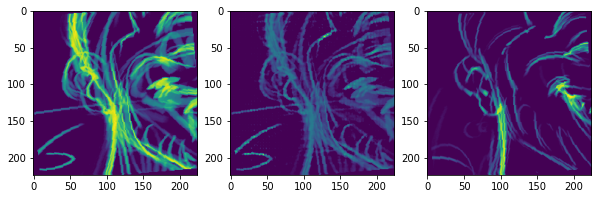

In [153]:
_, ax = plt.subplots(1, 3, figsize=(10, 5))
imshow(TF.to_pil_image(test_rough), ax=ax[0])
update_patch_and_visualize(rough_input, step=4.29886e-3, patch_sum=rough_sum.item(), ax=ax[1])
imshow(TF.to_pil_image(test_clean), ax=ax[2])

In [147]:
new = update_patch(rough_input, step=4.29886e-4, patch_sum=rough_sum.item())

In [139]:
arr = np.array(TF.to_pil_image(new))
arr.min(), arr.max()

(0, 255)

In [148]:
new.max(), new.min()

(tensor(0.2198), tensor(0.))

In [50]:
out_rough, out_clean

(tensor([-19.9768], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([-11.2318], device='cuda:0', grad_fn=<UnbindBackward0>))

In [49]:
out_clean

tensor([-11.2318], device='cuda:0', grad_fn=<UnbindBackward0>)

In [64]:
np.any(train_set.cpu().numpy() != 0)

True

In [43]:
paired_logits.reshape(10, 2)

tensor([[-0.3209, -0.2407],
        [-0.3039, -0.4693],
        [-0.3356, -0.3784],
        [-0.3439, -0.4817],
        [-0.3430, -0.4544],
        [-0.2328, -0.3932],
        [-0.3586, -0.4224],
        [-0.2410, -0.3755],
        [-0.3625, -0.4573],
        [-0.2607, -0.4074]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

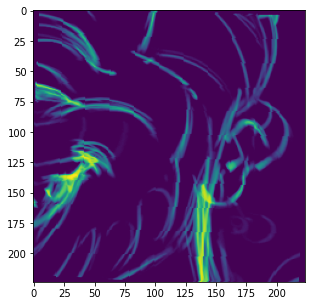

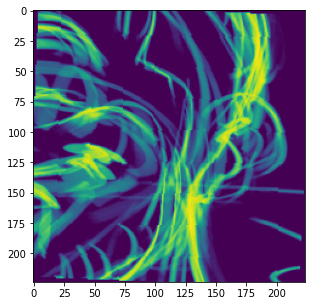

In [321]:
s = loader.sample()
imshow(TF.to_pil_image(s[0]), figsize=(5, 5))
imshow(TF.to_pil_image(s[1]), figsize=(5, 5))